![header](header.jpg)

# CMEMS IN SITU TRAINING FOR HIGH FREQUENCY RADARS

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction">1. Introduction</a></span></li>
        <li>
            <span><a href="#2.-Setup" data-toc-modified-id="2.-Setup">2. Setup</a></span>
            <ul>
                <li><span><a href="#2.1.-Python-packages" data-toc-modified-id="2.1.-Python-packages">2.1. Python packages</a></span></li>
                <li><span><a href="#2.2.-Auxiliary-functions" data-toc-modified-id="2.2.-Auxiliary-functions">2.2. Auxiliary functions</a></span></li>
            </ul>
        </li>
<li><span><a href="#3.-Reading-the-file" data-toc-modified-id="3.-Reading-the-file">3. Reading the file</a></span></li>
<li><span><a href="#4.-Data-visualization" data-toc-modified-id="4.-Data-visualization">4. Data visualization</a></span><ul>
    <li><span><a href="#4.1.-HFR-radial-sites" data-toc-modified-id="4.1.-HFR-radial-sites">4.1. HFR radial sites</a></span></li>
        <li><span><a href="#4.2.-Spatial-coverage" data-toc-modified-id="4.2.-Spatial-coverage">4.2. Spatial coverage</a></span></li>
    <li><span><a href="#4.3.-Velocity-vectors" data-toc-modified-id="4.3.-Velocity-vectors">4.3. Velocity vectors</a></span></li>
        <li><span><a href="#4.4.-Platform-performance" data-toc-modified-id="4.4.-Platform-performance">4.4. Platform performance</a></span></li>
    </ul></li>
        <li><span><a href="#5.-Wrap-up" data-toc-modified-id="5.-Wrap-up">5. Wrap-up</a></span></li>
    </ul>
</div>

***

## 1. Introduction
[Go back to the "Table of Contents"](#Table-of-Contents)

This notebook focuses on providing basic routines to plot (High Frequency Radar data. For doing this we will work with sample files downloaded from the Copernicus Marine Service (CMEMS) and available in the `data`folder. The Copernicus Marine Service is diseminating files containing data reproted by a wide range of platforms and among others, [High Frequency Radar](https://youtu.be/Ii83ob2cwhE). Presently you will find two products dedicated to this kind of observations:
- ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_OBSERVATIONS_013_048/ - Near Real Time Data
- ftp://my.cmems-du.eu/Core/INSITU_GLO_UV_L2_REP_OBSERVATIONS_013_044/ - Reprocessed data

<div class="alert alert-block alert-warning">
<b>WARNING</b>

***  
**Don't you have credentials yet to access CMEMS ftp server?** <br>Please go [here](https://resources.marine.copernicus.eu/?option=com_sla) to get the above credentials to be able to access CMEMS secured FTP server.
</div>

## 2. Setup
[Go back to the "Table of Contents"](#Table-of-Contents)

### 2.1. Python packages

For the notebook to properly run we need to first load the next packages available from the Jupyter Notebook Ecosystem. Please run the `next cell`:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import zipfile
import datetime
import os
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
%matplotlib inline

<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
***  
If any of them raises any error it means you need to install the module first. For doing so please:
1. Open a new cell in the notebook
2. Run <i>`!conda install packageName --yes`</i> or <i>`!conda install -c conda-forge packageName --yes`</i> or <i>`!pip install packageName`</i>
3. Import again!
<br><br>
Example: <i>how-to-solve import error for json2html module </i>

![region.png](errorImporting.gif)
</div>

### 2.2. Auxiliary functions

These functions will help us to obtain info from the netCDF files in a format ready to be passed as inputs for the diferent plots. They can be of course revisited and improved!:

In [2]:
def getSourceAntennas(ds):
    data = {'antennas':[] ,'bbox':[]}
    lats,lons = [],[]
    try:
        for name,lat,lon in zip(ds['SCDT'][0,:].astype('str').data,ds['SLTT'][0,:].data,ds['SLNT'][0,:].data):
            if np.isnan(lat) == False:
                name,lat,lon = name.strip(),round(lat, 4),round(lon, 4)
                data['antennas'].append({'name': name, 'lat': lat, 'lon': lon})
                lats.append(lat)
                lons.append(lon)
        data['bbox'] = [min(lons),max(lons),min(lats),max(lats)]
    except Exception as e:
        data = None
        print('An error ocurred when checking antennas')
    return data

In [3]:
def getCoverage(ds,flags, idx):
    data = None
    U = ds['EWCT'][idx,0].where(ds['QCflag'][idx,0].isin(flags))
    Y, X = ds[U.dims[0]].data, ds[U.dims[1]].data
    points = []
    try:
        for i in range(0,len(X)):
            for j in range(0,len(Y)):
                if np.isnan(U[j,i].data) == False:
                    points.append([U[j,i]['LONGITUDE'].data, U[j,i]['LATITUDE'].data])
        if len(points) != 0:
            vertices = ConvexHull(points).vertices
            coords = [[float(str(points[p][0])),float(str(points[p][1]))] for p in vertices]
            data = Polygon(coords)
        else:
            print('No coverage could be computed considering those flags.')
    except Exception as e:
        print('An error ocurred when computing coverage.')
    return data

In [4]:
def getPerformance(ds, flags, daysBack):
    reference = datetime.datetime.strptime(ds.time_coverage_end.split('T')[0], '%Y-%m-%d')
    start_date = reference - datetime.timedelta(daysBack)
    closerval = ds['TIME'].sel(TIME=start_date, method="nearest")
    idx_start = ds['TIME'].astype(str).values.tolist().index(str(closerval.data))
    data = []
    try:
        QCflag = ds['QCflag'][idx_start:,0]
        result, array = {}, []
        good_qc = np.isin(QCflag, flags)
        percentage_factor = 100/np.shape(QCflag)[0]
        percentage_good_qc = np.count_nonzero(good_qc, axis=0)*percentage_factor
        array = percentage_good_qc.flatten()
        nozeros = [item for item in array if item > 0]
        if len(nozeros) != 0:
            for i in range(1, 100, 1):
                subset = [val for val in array if val >= i]
                result[i] = (len(subset)*100)/len(nozeros)
            data = list(result.values())
        else:
            print('No performance metric could be computed with the selected flags')
    except Exception as e:
        print('An error ocurred when computing performance')
    return data

## 3. Reading the file

`Run the next cells` to see the HF Radar files already available in the /data folder:

In [5]:
dir_HF = os.path.join(os.getcwd(),'data') 

In [6]:
with zipfile.ZipFile(os.path.join(dir_HF,'data.zip'), 'r') as zip_ref:
    zip_ref.extractall(dir_HF)

In [7]:
dir_HF = os.path.join(os.getcwd(),'data') 
os.listdir(dir_HF)

['GL_TV_HF_HFR-TirLig-Total_202104.nc',
 'GL_TV_HF_HFR-DeltaEbro-Total_202104.nc',
 'GL_TV_HF_HFR-Ibiza-Total_202104.nc',
 'GL_RV_HF_HFR-TirLig-VIAR_202104.nc',
 'GL_RV_HF_HFR-DeltaEbro-ALFA_202104.nc',
 'data.zip',
 'GL_RV_HF_HFR-Ibiza-GALF_202104.nc']

`Set one` of the above available `file name` and `run the next cells`:

In [8]:
file = 'GL_TV_HF_HFR-TirLig-Total_202104.nc'
path = os.path.join(dir_HF, file)

In [9]:
ds = xarray.open_dataset(path)
ds.close()
ds

<xarray.Dataset>
Dimensions:           (DEPTH: 1, LATITUDE: 66, LONGITUDE: 121, MAXINST: 1, MAXSITE: 50, REFMAX: 1, TIME: 720)
Coordinates:
  * TIME              (TIME) datetime64[ns] 2021-04-01 ... 2021-04-30T23:00:0...
  * LATITUDE          (LATITUDE) float32 43.25 43.27 43.29 ... 44.39 44.41 44.42
  * LONGITUDE         (LONGITUDE) float32 7.507 7.532 7.557 ... 10.47 10.49
    DEPH              (DEPTH) float32 ...
Dimensions without coordinates: DEPTH, MAXINST, MAXSITE, REFMAX
Data variables:
    crs               int16 ...
    SDN_CRUISE        (TIME) |S50 ...
    SDN_STATION       (TIME) |S50 ...
    SDN_LOCAL_CDI_ID  (TIME) |S50 ...
    SDN_EDMO_CODE     (TIME, MAXINST) int16 ...
    SDN_REFERENCES    (TIME) |S250 ...
    SDN_XLINK         (TIME, REFMAX) |S250 ...
    EWCT              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    NSCT              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    EWCS              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    NSCS              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CCOV              (TIME, DEPTH, LATITUDE, LONGITUDE) float64 ...
    GDOP              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    TIME_QC           (TIME) float32 ...
    POSITION_QC       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    DEPH_QC           (TIME) float32 ...
    QCflag            (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    VART_QC           (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    GDOP_QC           (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    DDNS_QC           (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CSPD_QC           (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    NARX              (TIME) float32 ...
    NATX              (TIME) float32 ...
    SLTR              (TIME, MAXSITE) float64 ...
    SLNR              (TIME, MAXSITE) float64 ...
    SLTT              (TIME, MAXSITE) float64 ...
    SLNT              (TIME, MAXSITE) float64 ...
    SCDR              (TIME, MAXSITE) object ...
    SCDT              (TIME, MAXSITE) object ...
Attributes:
    site_code:                       HFR-TirLig
    platform_name:                   HFR-TirLig-Total
    wmo_platform_code:               
    ices_platform_code:              
    data_mode:                       R
    DoA_estimation_method:           PFIN: Direction Finding; TINO: Direction...
    calibration_type:                PFIN: APM; TINO: APM; VIAR: APM
    last_calibration_date:           PFIN: 2020-07-14T00:00:00Z; TINO: 2018-0...
    calibration_link:                PFIN: carlo.mantovani@cnr.it; TINO: carl...
    title:                           Near Real Time Surface Ocean Velocity by...
    summary:                         The data set consists of maps of total v...
    source:                          coastal structure
    source_platform_category_code:   17
    institution:                     National Research Council - Institute of...
    institution_edmo_code:           134 
    data_assembly_center:            European HFR Node
    data_type:                       HF radar total data
    feature_type:                    surface
    bottom_depth:                    
    format_version:                  1.4
    Conventions:                     CF-1.6 Copernicus-InSituTAC-FormatManual...
    update_interval:                 void
    citation:                        These data were collected and made freel...
    distribution_statement:          These data follow Copernicus standards; ...
    publisher_name:                  European HFR Node
    publisher_url:                   http://eurogoos.eu/
    publisher_email:                 euhfrnode@azti.es
    license:                         HF radar sea surface current velocity da...
    acknowledgment:                  ISMAR HF Radar Network has been establis...
    date_created:                    2021-04-03T19:15:39Z
    history:                         2021-04-01T00:00:00Z data collected. 202...
    processing_level

The above one is an overview of the content of the file: variables, dimensions, coordinates, global attributes...
<br>Let's list now the available variables: `run the next cell`

In [10]:
for var in ds.variables:
    try:
        print(var + ':' + ds[var].attrs['long_name'])
    except Exception as e:
        pass

TIME:Time
LATITUDE:Latitude of each location
LONGITUDE:Longitude of each location
SDN_CRUISE:Grid grouping label
SDN_STATION:Grid label
SDN_LOCAL_CDI_ID:SeaDataCloud CDI identifier
SDN_EDMO_CODE:European Directory of Marine Organisations code for the CDI partner
SDN_REFERENCES:Usage metadata reference
SDN_XLINK:External resource linkages
DEPH:Depth
EWCT:West-east current component
NSCT:South-north current component
EWCS:Standard deviation of surface eastward sea water velocity
NSCS:Standard deviation of surface northward sea water velocity
CCOV:Covariance of surface sea water velocity
GDOP:Geometrical dilution of precision
TIME_QC:Time quality flag
POSITION_QC:Position quality flag
DEPH_QC:Depth quality flag
QCflag:Overall quality flag
VART_QC:Variance threshold quality flag
GDOP_QC:GDOP threshold quality flag
DDNS_QC:Data density threshold quality flag
CSPD_QC:Velocity threshold quality flag
NARX:Number of receive antennas
NATX:Number of transmit antennas
SLTR:Receive antenna latitude

In In Situ TAC netCDFs all variables are linked to another called the same plus '_QC'. This 'twin' variable contains a quality flag for each value in the paired variable. `run the next cell` to check the flag values convention:

In [11]:
pd.DataFrame(data=ds['QCflag'].attrs['flag_values'],
             index=ds['QCflag'].attrs['flag_meanings'].split(' '), columns=['quality flag'])

,quality flag
no_qc_performed,0
good_data,1
probably_good_data,2
bad_data_that_are_potentially_correctable,3
bad_data,4
value_changed,5
not_used,6
nominal_value,7
interpolated_value,8
missing_value,9


Users are recommended to use only the data flagged as 1, they so called 'good data'.

## 4. Data visualization

[Go back to the "Table of Contents"](#Table-of-Contents)

### 4.1. HFR radial sites

As it was exposed before, the source of the data reported by an HF Radar platform are the antennas. <br>Let's check the name and location of the ones that produced this file: `tun the next cell`

In [12]:
info = getSourceAntennas(ds)
info['antennas']

[{'name': 'PFIN', 'lat': 44.299, 'lon': 9.218},
 {'name': 'TINO', 'lat': 44.026, 'lon': 9.849},
 {'name': 'VIAR', 'lat': 43.858, 'lon': 10.237}]

Let's see those on a map!: `run the next cell`

In [13]:
extent = [info['bbox'][0]-1,info['bbox'][1]+1,info['bbox'][2]-1,info['bbox'][3]+1] #minX,maxX,#minY,maxY

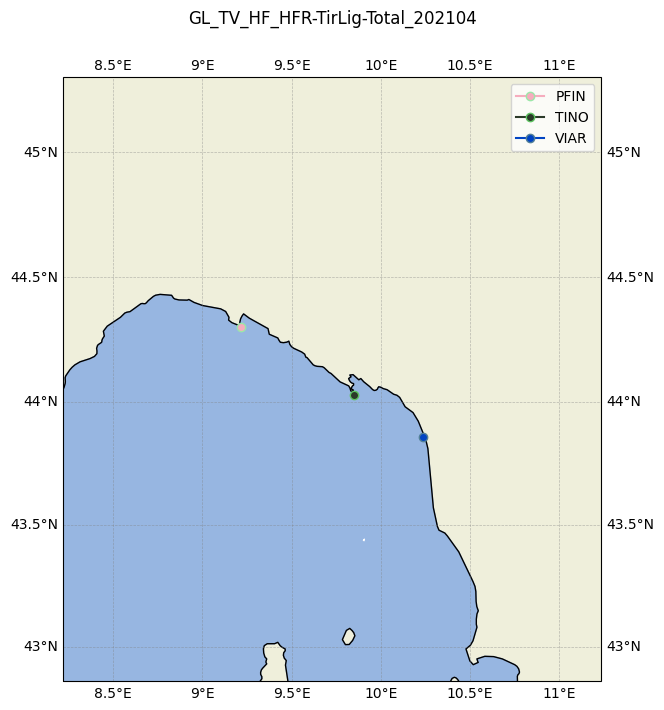

In [45]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add points
ax.legend()#add legend
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(extent)#personalized limts
plt.title(ds.id, pad=25)

#uncomment next lines to save the figure
#figure_name = ds.id+'_antennas.png'
#plt.savefig(figure_name) 
plt.show()

### 4.2. Spatial coverage

As stated before, the HF Radar platforms report maps of currents near the coastline. 
<br>Let's check the coverage of such maps!

Choose first a timestamp: `set it in the next cell and run it`

In [15]:
timestamp = '2021-04-02 10:00'
datetime_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M')

Let's calculate the closer available timestamp in the file: `run the next cell` 

In [16]:
closerval = ds['TIME'].sel(TIME=datetime_obj, method="nearest")
idx = ds['TIME'].astype(str).values.tolist().index(str(closerval.data))
print('Requested timestamp %s | Closer timestamp %s '%(timestamp,closerval.data))

Requested timestamp 2021-04-02 10:00 | Closer timestamp 2021-04-02T09:59:59.999996672 


Choose flags to consider: `run the next cell`

In [17]:
flags = [0,1,2,3,4,5,6,7,8,9]

Let's now compute the coverage for such timestamp and flags: `run the next cell`

In [18]:
coverage = getCoverage(ds,flags,idx)

Let's finally plot it: `run the next cells`

In [19]:
extent = [info['bbox'][0]-1,info['bbox'][1]+1,info['bbox'][2]-1,info['bbox'][3]+1] #minX,maxX,#minY,maxY

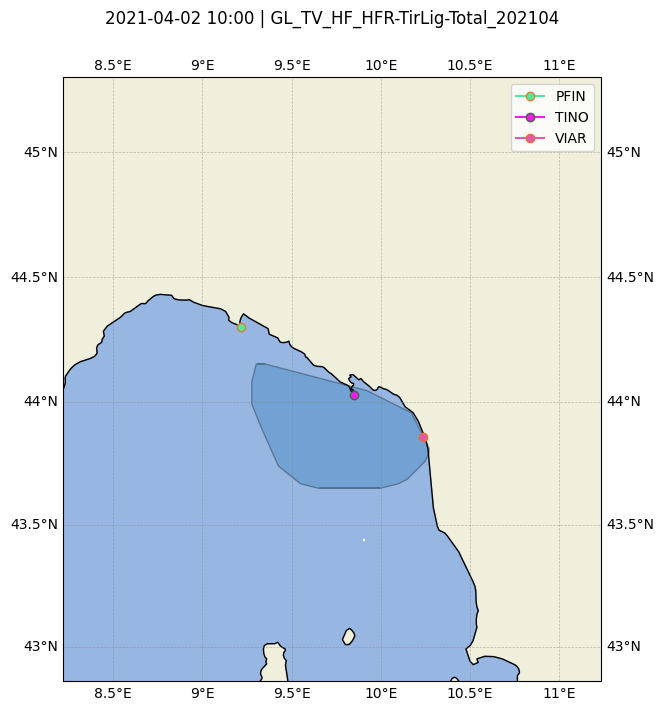

In [46]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add points
ax.add_geometries([coverage], crs=cartopy.crs.PlateCarree(), alpha=0.3, edgecolor='k')
ax.legend()#add legend
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(extent)#personalized limts
plt.title(timestamp+' | '+ds.id, pad=25)

#uncomment next lines to save the figure
#figure_name = ds.id+'_coverage.png'
#plt.savefig(figure_name) 
plt.show()

Let's be more strict with QC flags!:`run the next cells`

In [21]:
flags = [1,2]

In [22]:
coverage = getCoverage(ds,flags, idx)

In [23]:
extent = [info['bbox'][0]-1,info['bbox'][1]+1,info['bbox'][2]-1,info['bbox'][3]+1] #minX,maxX,#minY,maxY

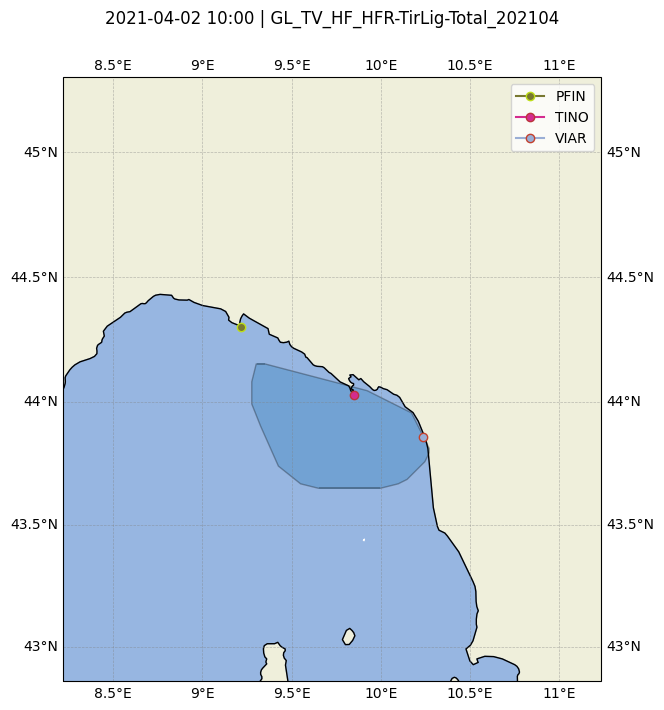

In [47]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add points
if coverage:
    ax.add_geometries([coverage], crs=cartopy.crs.PlateCarree(), alpha=0.3, edgecolor='k')
ax.legend()#add legend
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(extent)#personalized limts
plt.title(timestamp+' | '+ds.id, pad=25)

#uncomment next lines to save the figure
#figure_name = ds.id+'_goodcoverage.png'
#plt.savefig(figure_name) 
plt.show()

### 4.3. Velocity vectors

Let's plot now the velocity vectors!
<br>Choose first a timestamp: `set it in the next cell and run it`

In [25]:
timestamp = '2021-04-02 10:00'
datetime_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M')

Let's calculate the closer available timestamp in the file: `tun the next cell` 

In [26]:
closerval = ds['TIME'].sel(TIME=datetime_obj, method="nearest")
idx = ds['TIME'].astype(str).values.tolist().index(str(closerval.data))
print('Requested timestamp %s | Closer timestamp %s '%(timestamp,closerval.data))

Requested timestamp 2021-04-02 10:00 | Closer timestamp 2021-04-02T09:59:59.999996672 


Choose also a cnfiguration for the colorbar: color map and max/min ranges

In [27]:
cmap = 'jet'
norm = colors.Normalize(vmin=0, vmax=0.4)

Choose flags to consider:

In [58]:
flags = [1,2]

Now let's plot the currents for the closest available time!: `run the next cell`

In [59]:
extent = [info['bbox'][0]-1,info['bbox'][1]+1,info['bbox'][2]-1,info['bbox'][3]+1] #minX,maxX,#minY,maxY

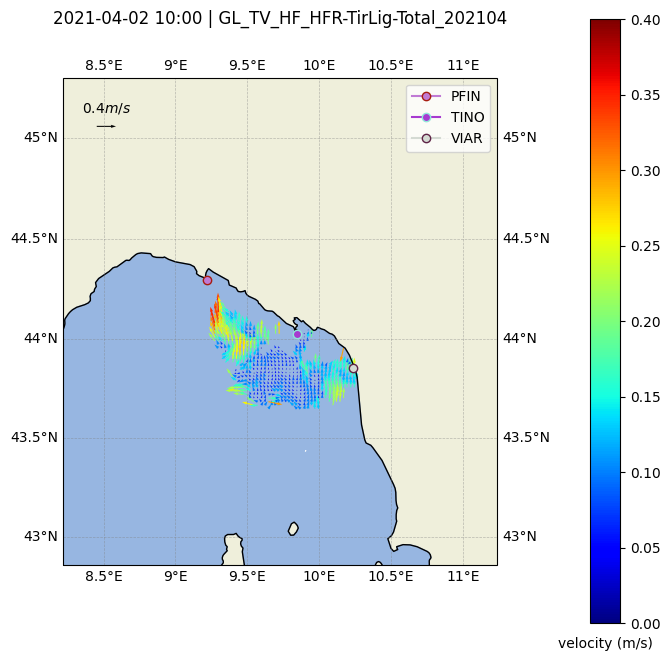

In [60]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
#plotting antennas
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add points
ax.legend()#add legend
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(extent)#personalized limts
#quiver plot (set vectors, colormaps and colorbars)
x,y,u,v = ds['LONGITUDE'].data,ds['LATITUDE'].data,ds['EWCT'][idx,0],ds['NSCT'][idx,0]
U = u.where(ds['QCflag'][idx,0].isin(flags)).data
V = v.where(ds['QCflag'][idx,0].isin(flags)).data
m = (U ** 2 + V ** 2) ** 0.5
Q=ax.quiver(x, y, U,V,m,transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, scale=9)
#arrow reference
ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
#colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('velocity (m/s)', labelpad=10, )
plt.title(timestamp+' | '+ds.id, pad=25)
#uncomment next lines to save the figure
#figure_name = ds.id+'_vectors.png'
#plt.savefig(figure_name) 
plt.show()

Let's add an image as basemap better!:

In [61]:
tile_img = cimgt.StamenTerrain()#https://scitools.org.uk/cartopy/docs/v0.18/_modules/cartopy/io/img_tiles.html

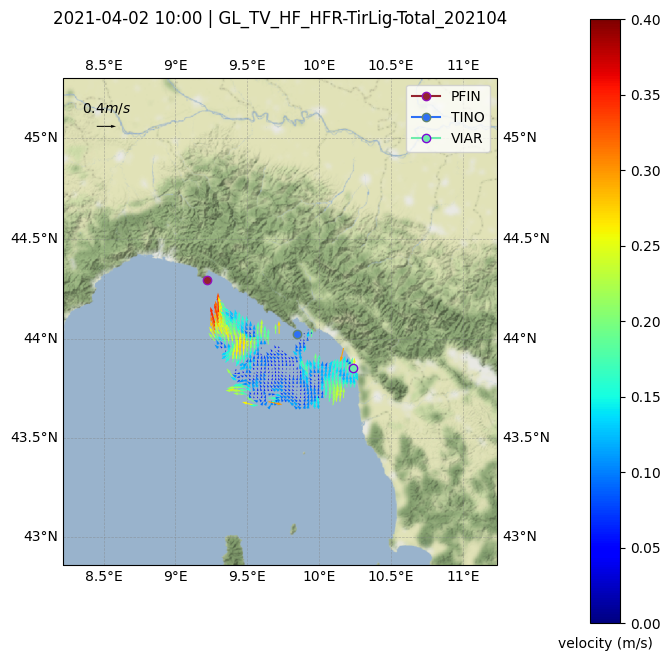

In [63]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
#plotting antennas
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add points
ax.legend()#add legend
zoom = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) #zoom based on limits
ax.add_image(tile_img,int(zoom))#adding tile
ax.set_extent(extent)#personalized limts
#quiver plot (set vectors, colormaps and colorbars)
x,y,u,v = ds['LONGITUDE'].data,ds['LATITUDE'].data,ds['EWCT'][idx,0],ds['NSCT'][idx,0]
U = u.where(ds['QCflag'][idx,0].isin(flags)).data
V = v.where(ds['QCflag'][idx,0].isin(flags)).data
m = (U ** 2 + V ** 2) ** 0.5
Q=ax.quiver(x, y, U,V,m,transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, scale=9)
#arrow reference
ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
#colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('velocity (m/s)', labelpad=10, )
plt.title(timestamp+' | '+ds.id, pad=25)
#uncomment next lines to save the figure
#figure_name = ds.id+'_vectors2.png'
#plt.savefig(figure_name) 
plt.show()

### 4.4. Platform performance

Performance metrics are calculated based on the 80/80 metric from [MARACOOS](https://ieeexplore.ieee.org/document/6404809); which basically provides an indicator for the spatial and temporal availability of a given HF Radar with a common goal: get closer to the 80%/80% spatial and temporal availability.

Let's calculate those for the last 30 days of our HF Radar: `run the next cells`:

In [33]:
flags = [0,1,2,3,4,5,6,7,8,9]

In [34]:
metrics = getPerformance(ds,flags,30)

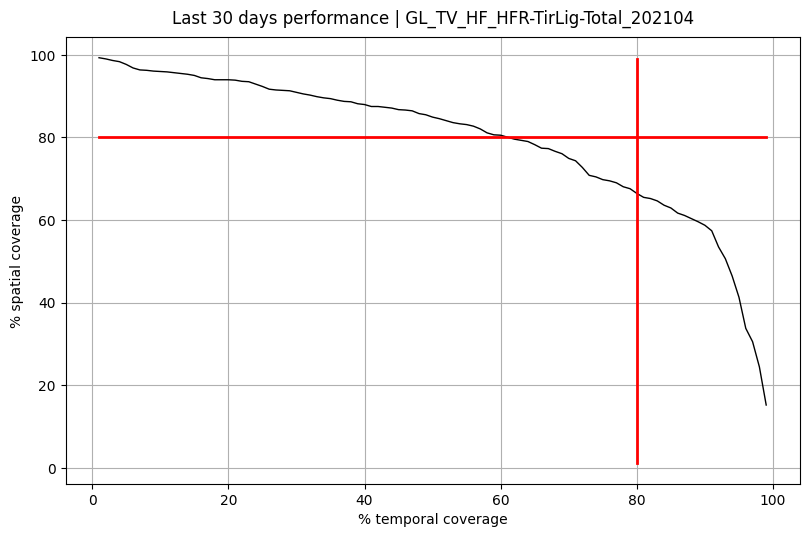

In [38]:
plt.figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
x = range(1,100,1)
ref = [80 for a in x]
if metrics:
    plt.plot(x,metrics, color = 'k', linewidth=1)
plt.plot(x,ref,color = 'r', linewidth=2)
plt.plot(ref,x,color = 'r', linewidth=2)
plt.grid(True)
plt.tight_layout()
plt.title('Last 30 days performance | %s'%(ds.id), pad=10)
plt.gca().set_xlabel('% temporal coverage')
plt.gca().set_ylabel('% spatial coverage')
plt.show()

## 5. Wrap-up
[Go back to the "Table of Contents"](#Table-of-Contents)

So far you should already know how to deal with gridded-like data from HF Radar platforms. <br> `If you don't please ask us! it is the moment!`